* cookie和session
* xsrf攻击
* 日志
* 数据库操作
* 用户登录和跳转
* 应答response的压缩或其他处理
* 中间件
* 重定向, 多级路由
* 数据的流式取和流式返回
* 配置文件采用的格式以及解析方式
* 信号
* websocket
* wsgi
* 部署

# cookie和session

## cookie

### 普通cookie

* [cookies](#ccc)(self)
* [get_cookie](#ccgc)(self, name, default=None)
* [set_cookie](#ccsc)(self, name, value, domain=None, expires=None, path="/", expires_days=None, **kwargs)
* [clear_cookie](#ccclc)(self, name, path="/", domain=None)
* [clear_all_cookies](#cac)(self)
* [`_generate_headers(self)`](#ccgh): 生成响应头

#### <a id="ccgh">`_generate_headers`</a>

In [1]:
def _generate_headers(self):
    lines = [self.request.version + " " + str(self._status_code) + " " +
             httplib.responses[self._status_code]]
    lines.extend(["%s: %s" % (n, v) for n, v in self._headers.iteritems()])
    for cookie_dict in getattr(self, "_new_cookies", []):
        # cookie_dict 是Cookie对象
        # cookie_dict是{name: Morsel对象}
        # Morsel: OutputString就是字符串的uid=c2bc7fe6ce85-4daa-16c4-6f9e-9e7031fd
        # Morsel: value就是字符串的c2bc7fe6ce85-4daa-16c4-6f9e-9e7031fd
        # 最终返回给页面的有很多的"Set-Cookie: ": value
        for cookie in cookie_dict.values():
            lines.append("Set-Cookie: " + cookie.OutputString(None))
    return "\r\n".join(lines) + "\r\n\r\n"

#### <a id="ccsc">set_cookie</a>
set_cookie: 给`self._new_cookies`append一个Cookie对象, 即使name相同也是直接append.
接收的参数expires是一个datetime类型, expires_days是一个int类型, 如果两个都设置了, 那么以expires设置的为准(这个更贴近真实含义).

In [2]:
def set_cookie(self, name, value, domain=None, expires=None, path="/",
               expires_days=None, **kwargs):
    """Sets the given cookie name/value with the given options.
    """
    name = _utf8(name)
    value = _utf8(value)
    if re.search(r"[\x00-\x20]", name + value):
        # Don't let us accidentally inject bad stuff
        raise ValueError("Invalid cookie %r: %r" % (name, value))
    if not hasattr(self, "_new_cookies"):
        self._new_cookies = []
    # py3 中使用http.cookie.SimpleCookie(), 这个对象是继承于字典的
    new_cookie = Cookie.BaseCookie()
    self._new_cookies.append(new_cookie)
    new_cookie[name] = value
    # 一系列判断条件，分别给name的cookie设置上domain, expires, path等
    if domain:
        new_cookie[name]["domain"] = domain
    if expires_days is not None and not expires:
        expires = datetime.datetime.utcnow() + datetime.timedelta(
            days=expires_days)
    if expires:
        timestamp = calendar.timegm(expires.utctimetuple())
        # 'Wed, 19 Jun 2019 08:50:03 GMT'
        new_cookie[name]["expires"] = email.utils.formatdate(
            timestamp, localtime=False, usegmt=True)
    if path:
        new_cookie[name]["path"] = path
    for k, v in kwargs.iteritems():
        new_cookie[name][k] = v

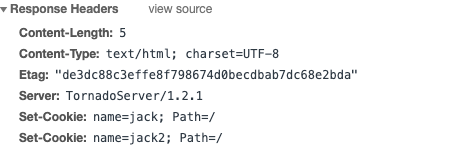

#### <a id="ccgc">get_cookie</a>

用来获取浏览器的cookie，内部调用了self.cookies, 原本以为是直接操作`self._new_cookies`列表的。

In [6]:
def get_cookie(self, name, default=None):
    """Gets the value of the cookie with the given name, else default."""
    # 因为Cookie对象可以理解为一个字典，字典里包含很多个name
    if name in self.cookies:
        return self.cookies[name].value
    return default

#### <a id="ccc">cookies</a>

cookies: 用来获取浏览器发送的cookie, 返回<font color="red">一个</font>load字符串的`self._cookies`的Cookie对象。

In [5]:
@property
def cookies(self):
    """A dictionary of Cookie.Morsel objects."""
    if not hasattr(self, "_cookies"):
        self._cookies = Cookie.BaseCookie()
        if "Cookie" in self.request.headers:
            try:
                self._cookies.load(self.request.headers["Cookie"])
            except:
                self.clear_all_cookies()
    return self._cookies

#### <a id="ccclc">clear_cookie</a>

清除掉浏览器的某一个name的cookie

In [ ]:
def clear_cookie(self, name, path="/", domain=None):
    """Deletes the cookie with the given name."""
    expires = datetime.datetime.utcnow() - datetime.timedelta(days=365)
    self.set_cookie(name, value="", path=path, expires=expires,
                    domain=domain)

#### <a id="cac">clear_all_cookies</a>

清楚掉浏览器的所有name的cookie, 这里的clear_all_cookies和clear_cookie 两个函数的设置体现了一个函数完成一项功能的规范

In [ ]:
def clear_all_cookies(self):
    """Deletes all the cookies the user sent with this request."""
    for name in self.cookies.iterkeys():
        self.clear_cookie(name)

### 加密cookie

加密cookie对于我们自己写一些简单的加密的也是一种不错的思想借鉴。

* [set_secure_cookie](#ecssc)(self, name, value, expires_days=30, **kwargs)
* [get_secure_cookie](#ecgsc)(self, name, include_name=True, value=None)

涉及到的几个加密函数
* [create_signed_value](#eccsv)(name, value)
* [`_cookie_signature`](#eccs)(self, *parts)

#### <a id="eccs">`_cookie_signature`</a>

使用加密cookie需要在settings里面提供一个cookie_secret，让用户去指定hmac的秘钥。`_cookie_signature`完成对parts数组所有元素的update并返回16进制的加密字符串。

In [ ]:
def _cookie_signature(self, *parts):
    self.require_setting("cookie_secret", "secure cookies")
    hash = hmac.new(self.application.settings["cookie_secret"],
                    digestmod=hashlib.sha1)
    for part in parts: hash.update(part)
    return hash.hexdigest()

#### <a id="eccsv">create_signed_value</a>

利用当前时间戳以及传入的参数name和value组成一个签名cookie, value进行base64加密，signature使用name, value, timestamp三者的hash算法，最终使用base64加密的value, 时间戳以及signature。

In [ ]:
def create_signed_value(self, name, value):
    timestamp = str(int(time.time()))
    value = base64.b64encode(value)
    signature = self._cookie_signature(name, value, timestamp)
    value = "|".join([value, timestamp, signature])
    return value

#### <a id="ecssc">set_secure_cookie</a>

set_secure_cookie方法其实内部就2行代码，self.create_signed_value(name, value)以及self.set_cookie, 体现了方法的精简性。使用加密cookie默认过期时间是30days.

In [ ]:
def set_secure_cookie(self, name, value, expires_days=30, **kwargs):
    self.set_cookie(name, self.create_signed_value(name, value),
                    expires_days=expires_days, **kwargs)

#### <a id="ecgsc">get_secure_cookie</a>

对加密的cookie解密出想要的value. 其实进行base64解密一下即可，只是在解密前还需要做一系列check操作：check cookie是否被篡改，check cookie的时间是否过期等。get_cookie仅仅是根据name拿到对应的value, 并没有这些check操作。

In [ ]:
def get_secure_cookie(self, name, include_name=True, value=None):
    """Returns the given signed cookie if it validates, or None.

    In older versions of Tornado (0.1 and 0.2), we did not include the
    name of the cookie in the cookie signature. To read these old-style
    cookies, pass include_name=False to this method. Otherwise, all
    attempts to read old-style cookies will fail (and you may log all
    your users out whose cookies were written with a previous Tornado
    version).
    """
    if value is None: value = self.get_cookie(name)
    if not value: return None
    parts = value.split("|")
    if len(parts) != 3: return None
    # 对浏览器的cookie中发送的值进行签名
    if include_name:
        signature = self._cookie_signature(name, parts[0], parts[1])
    else:
        signature = self._cookie_signature(parts[0], parts[1])
    # 比较新计算出的签名和cookie中的签名是否一致，防止有篡改cookie的行为
    if not _time_independent_equals(parts[2], signature):
        logging.warning("Invalid cookie signature %r", value)
        return None
    timestamp = int(parts[1])
    # cookie 过期
    if timestamp < time.time() - 31 * 86400:
        logging.warning("Expired cookie %r", value)
        return None
    # cookie 不能设置超过1个月
    if timestamp > time.time() + 31 * 86400:
        logging.warning("Cookie timestamp in future; possible tampering %r", value)
        return None
    if parts[1].startswith("0"):
        logging.warning("Tampered cookie %r", value)
    try:
        # 真正对value进行base64解密
        return base64.b64decode(parts[0])
    except:
        return None

## session



### 自定义session

这里为了简单，使用一个字典(当然也可以替换成数据库)来存session_id和session_value的关系，{session_id1: {}, session_id2: {}}.


In [ ]:
import time
import hashlib
import os

import tornado.web
import tornado.ioloop

session_container = {}

class Session(object):

    session_key = "session"

    def __init__(self, request):
        id_from_cookie = request.get_cookie(self.__class__.session_key)
        if not id_from_cookie:
            self._id = self._gen_session_id()
        else:
            self._id = id_from_cookie
        request.set_cookie(self.__class__.session_key, self._id)

    def __getitem__(self, key):
        session_container[self._id].get(key)

    def __setitem__(self, key, value):
        session_container.setdefault(self._id, {}).update({key, value})

    def __delitem__(self, key):
        session_container[self._id].pop(key, None)

    def _gen_session_id(self):
        md5 = hashlib.md5()
        md5.update("%s%s"%(os.urandom(16), time.time()))
        return md5.hexdigest()


class BaseHandler(tornado.web.RequestHandler):

    def initialize(self):
        self.session = Session(self)


class MainHandler(BaseHandler):

    def get(self):
        print(self.session['user'])
        self.write('index')


class LoginHandler(BaseHandler):

    def get(self):
        self.render('login.html', **{'status': ''})

    def post(self, *args, **kwargs):

        username = self.get_argument('name')
        password = self.get_argument('pwd')
        if username == 'wanhua' and password == '123456':
            self.session['user'] = 'wanhua'

            self.redirect('/index')
        else:
            self.render('login.html', **{'status': '用户名或密码错误'})


settings = {
    'template_path': 'template',
    'static_path': 'static',
    'static_url_prefix': '/static/',
    'cookie_secret': 'aiuasdhflashjdfoiuashdfiuh',
    'login_url': '/login'
}

application = tornado.web.Application([
    (r"/index", MainHandler),
    (r"/login", LoginHandler),
], **settings)

if __name__ == "__main__":
    application.listen(8888)
    tornado.ioloop.IOLoop.instance().start()

### 分布式session


一致性hash算法详情：https://www.jianshu.com/p/e8fb89bb3a61

In [ ]:
# coding: utf8
import sys
import bisect
if sys.version_info >= (2, 5):
    import hashlib
    md5_constructor = hashlib.md5
else:
    import md5
    md5_constructor = md5.new

class HashRing(object):
    def __init__(self, nodes, replicas=5):
        self.replicas = replicas
        self.rings = {}
        self._sorted_keys = []
        self.nodes = nodes
        for node in self.nodes:
            self.add_node(node)

    def add_node(self, node):
        """
        新增节点
        :param node: {'host':'127.0.0.1:8002','weight':1}，其中第一个元素表示节点，第二个元素表示该节点的权重。
        :return:
        """
        host = node.get("host", "")
        weight = node.get("weight", 1)
        assert host, (1, "节点的地址不能为空.")
        for i in range(weight * self.replicas):
            virtual_node = f"{host}#{i}"
            key = self._gen_key(virtual_node)
            bisect.insort_right(self._sorted_keys, key)
            self.rings[key] = host

    def remove_node(self, node):
        """
        移除节点
        :param node: '127.0.0.1:8000'
        :return:
        """
        for key, host in self.rings.items():
            if host == node:
                self._sorted_keys.remove(key)
                del self.rings[key]

    def _gen_key(self, key):
        m = md5_constructor()
        m.update(key.encode('utf-8'))
        return m.hexdigest()

    def _get_node_pos(self, string_key):
        """
        根据string_key得到应该存在self._sorted_keys的位置
        bisect.bisect_left(L,x)　 在L中查找x, x存在时返回x左侧的位置, x不存在返回应该插入的位置
        bisect.bisect_right(L,x)   在L中查找x, x存在时返回x右侧的位置, x不存在返回应该插入的位置
        bisect.insort_left(L,x)   将x插入到列表L中, x存在时插入在左侧
        bisect.insort_right(L,x)   将x插入到列表L中, x存在时插入在右侧　
        :param key:
        :return:
        """
        key = self._gen_key(string_key)
        pos = bisect.bisect_right(self._sorted_keys, key)
        if pos == len(self._sorted_keys):
            # 通过这种操作让ring从线性变为环
            return 0
        return pos

    def get_node(self, string_key):
        """
        对object进行hash得到key, 寻找key应该存放在哪个节点上.
        算法是: 返回最早比string_key大的节点, string_key沿顺时针走到最早比string_key大的节点
        :param string_key: object
        :return:
        """
        pos = self._get_node_pos(string_key)
        return self.rings[self._sorted_keys[pos]]


nodes = [
    {'host': '127.0.0.1:8000', 'weight': 1},
    {'host': '127.0.0.1:8001', 'weight': 2},
    {'host': '127.0.0.1:8002', 'weight': 1},
]
ring = HashRing(nodes)
node = ring.get_node('12123121312')
print(node)

In [ ]:
class Session(object):

    session_key = "session"

    def __init__(self, request):
        id_from_cookie = request.get_cookie(self.__class__.session_key)
        if not id_from_cookie:
            self._id = self._gen_session_id()
        else:
            self._id = id_from_cookie
        request.set_cookie(self.__class__.session_key, self._id)

    def __getitem__(self, key):
        # 根据 self._id ，在一致性哈西中找到其对应的服务器IP
        # 找到相对应的redis服务器，如： r = redis.StrictRedis(host='localhost', port=6379, db=0)
        # 使用python redis api 链接
        # 获取数据，即：
        # return self._redis.hget(self._id, name)

    def __setitem__(self, key, value):
        # 根据 self._id ，在一致性哈西中找到其对应的服务器IP
        # 使用python redis api 链接
        # 设置session
        # self._redis.hset(self._id, name, value)


    def __delitem__(self, key):
        # 根据 self._id 找到相对应的redis服务器
        # 使用python redis api 链接
        # 删除，即：
        return self._redis.hdel(self._id, name)

# xsrf

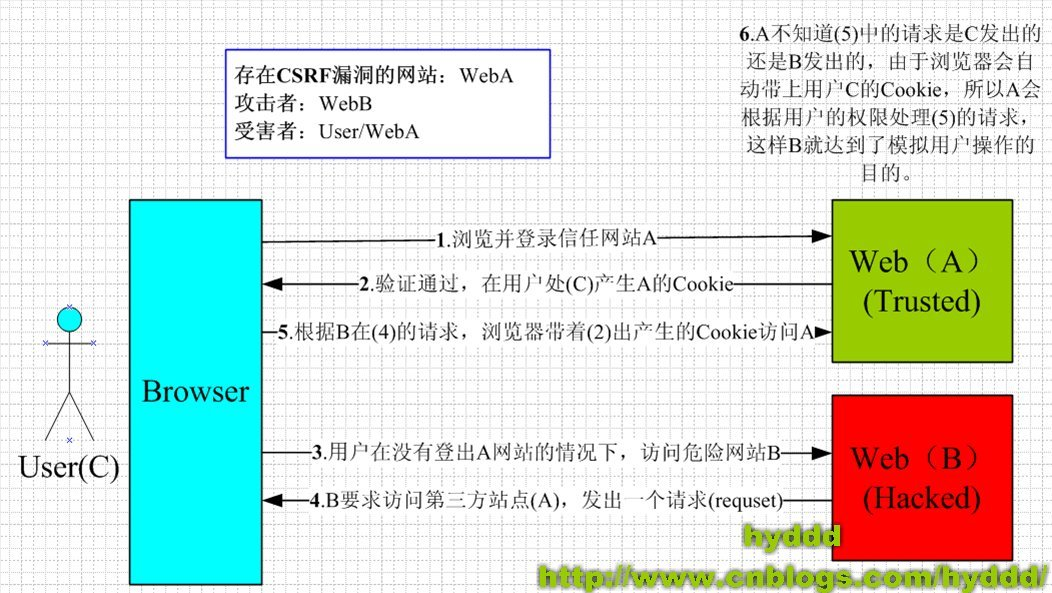
要完成一次CSRF攻击，受害者必须依次完成两个步骤：
1. 登录受信任网站A，并在本地生成Cookie。
2. 在不登出A的情况下，访问危险网站B。

如果在B网站通过get请求去访问A网站的url，那么浏览器就会带着A网站的cookie去访问,  如果B网站通过post方式,  伪造一些表单数据，然后去发A网站的url, 这时浏览器会拿着表单数据和A网站的cookie把请求发送到A网站。

tornado默认的xsrf防护是这样做的：

由于第三方站点B没有直接在js里访问A网站cookie数据的权限(同源策略,所谓同源是指,域名,协议,端口相同。不同源的客户端脚本(javascript、ActionScript)在没明确授权的情况下，不能读写对方的资源。在B网站的js里document.cookie拿到的仅仅是B网站的cookie), 所以我们可以要求每个请求包括一个特定的参数值作为令牌来匹配存储在cookie中的对应值，如果两者匹配，我们的应用认定请求有效。而第三方站点无法在请求中包含令牌cookie值，这就有效地防止了不可信网站发送未授权的请求。

换句话说, cookie中存放了一个随机值, <font color="red">发送的请求中</font>带着这个随机值，服务器端对此进行比较。

## 开启XSRF保护
要开启XSRF保护，需要在Application的构造函数中添加xsrf_cookies参数：


In [ ]:
app = tornado.web.Application(
    [(r"/", IndexHandler),],
    debug=True,
    cookie_secret = "2hcicVu+TqShDpfsjMWQLZ0Mkq5NPEWSk9fi0zsSt3A=",
    xsrf_cookies = True
)

## 为前端设置xsrf

### 通过模板加载的页面
只需在模板中添加以下语句：

`{% module xsrf_form_html() %}`

模板中添加的语句帮我们做了两件事：

1. 为浏览器设置了_xsrf的Cookie（注意此Cookie浏览器关闭时就会失效）
2. 为模板的表单中添加了一个隐藏的输入名为_xsrf，其值为_xsrf的Cookie值

## 不通过模板加载的页面
对于不使用模板的应用来说，首先要设置_xsrf的Cookie值，可以在任意的Handler中通过获取self.xsrf_token的值来生成_xsrf并设置Cookie。

下面两种方式都可以起到设置_xsrf Cookie的作用。

In [ ]:
class XSRFTokenHandler(RequestHandler):
    """专门用来设置_xsrf Cookie的接口"""
    def get(self):
        self.xsrf_token
        self.write("Ok")
 
class StaticFileHandler(tornado.web.StaticFileHandler):
    """重写StaticFileHandler，构造时触发设置_xsrf Cookie"""
    def __init__(self, *args, **kwargs):
        super(StaticFileHandler, self).__init__(*args, **kwargs)
        self.xsrf_token

* xsrf_token(self)
* check_xsrf_cookie(self)

思考一下这两个函数分别做了些什么事：xsrf_token设置了cookie，cookie的name是`_xsrf`, value是随机字符串。在服务端这边也存了一个值，只不过这个值不是存在数据库中的，而是存在RequestHandler的一个属性中`self._xsrf_token`(其实也就是cookie里的_xsrf，所以本质上比较的也是cookie里的值和表单提交或请求头的值是否一致).以后check的时候可以用这个和提交过来的进行比较。
check_xsrf_cookie就是检查请求中的token和`self._xsrf_token`是否相等。其中请求中的token有3个来源：请求体或queryparam提交的数据名为`_xsrf`，请求头X-Xsrftoken或X-Csrftoken携带过来的。

In [1]:
@property
def xsrf_token(self):
    """The XSRF-prevention token for the current user/session.

    To prevent cross-site request forgery, we set an '_xsrf' cookie
    and include the same '_xsrf' value as an argument with all POST
    requests. If the two do not match, we reject the form submission
    as a potential forgery.
    """
    if not hasattr(self, "_xsrf_token"):
        token = self.get_cookie("_xsrf")
        if not token:
            token = binascii.b2a_hex(uuid.uuid4().bytes)
            expires_days = 30 if self.current_user else None
            self.set_cookie("_xsrf", token, expires_days=expires_days)
        self._xsrf_token = token
    return self._xsrf_token

In [1]:
def check_xsrf_cookie(self):
    """Verifies that the '_xsrf' cookie matches the '_xsrf' argument.

    To prevent cross-site request forgery, we set an '_xsrf'
    cookie and include the same value as a non-cookie
    field with all POST requests. If the two do not match, we
    reject the form submission as a potential forgery.

    The _xsrf value may be set as either a form field named _xsrf
    or in a custom HTTP header named X-XSRFToken or X-CSRFToken
    (the latter is accepted for compatibility with Django).
    """
    token = (self.get_argument("_xsrf", None) or
             self.request.headers.get("X-Xsrftoken") or
             self.request.headers.get("X-Csrftoken"))
    if not token:
        raise HTTPError(403, "'_xsrf' argument missing from POST")
    if self.xsrf_token != token:
        raise HTTPError(403, "XSRF cookie does not match POST argument")

# 日志

## 自定义日志类

自定义一个日志类, 可以手动控制日志的打印。


In [ ]:
import logging
import os
import sys

from logging import handlers
from functools import wraps


def get_logger(request):
    return Logger(request)


class Logger(object):
    format_string = "{asctime} user: {user} {message}"

    def __init__(self, request, name=__file__, json=False, level=logging.INFO):
        self.request = request
        self.name = name
        self.json = json
        self.level = level
        self.logger = logging.getLogger(self.name)
        self.logger.setLevel(level)
        if os.getenv("LOG_FILE") in ["True", "true", "1"]:
            log_dir = os.getenv("LOG_DIR", "/tmp")
            filename = os.getenv("LOG_FILENAME", "access.log")
            os.makedirs(log_dir, exist_ok=True)
            file_handler = handlers.RotatingFileHandler(
                os.path.join(log_dir, filename),
                maxBytes=10 * 1024 * 1024,
                backupCount=5,
                encoding="utf8"
            )
            self.set_handler(file_handler)
        else:
            self.set_handler(logging.StreamHandler(sys.stdout))

    def __getattr__(self, item):
        if item.upper() in logging._nameToLevel:
            func = getattr(self.logger, item)

            @wraps(func)
            def wrapper(*args, **kwargs):
                extra = kwargs.pop("extra", {})
                user = self.request.current_user
                extra.setdefault('user', getattr(user, "name", None))
                # kwargs的key必须是extra
                kwargs["extra"] = extra
                return func(*args, **kwargs)

            return wrapper

        raise AttributeError

    def set_handler(self, handler):
        handler.setLevel(logging.DEBUG)
        handler.setFormatter(self._get_formatter())
        self.logger.addHandler(handler)

    def _get_formatter(self):
        if self.json:
            from pythonjsonlogger import jsonlogger
            return jsonlogger.JsonFormatter()
        return logging.Formatter(
            self.format_string,
            style="{",
            datefmt='%Y-%m-%d %H:%M:%S %p')


class MainHandler(tornado.web.RequestHandler):

    def initialize(self):
        self.logger = get_logger(self)

    def get(self):
        self.logger.info("just run")
        self.write("world")

## tornado日志自定义



In [ ]:
def log_func(handler):
    if handler.get_status() < 400:
        log_method = access_log.info
    elif handler.get_status() < 500:
        log_method = access_log.warning
    else:
        log_method = access_log.error
    request_time = 1000.0 * handler.request.request_time()
    log_method("%d %s %s (%s) %s %s %.2fms",
               handler.get_status(), handler.request.method,
               handler.request.uri, handler.request.remote_ip,
               handler.request.headers["User-Agent"],
               handler.request.arguments,
               request_time)


class QYKApplication(tornado.web.Application):
    def __init__(self, config, webpack_setting, _redis, session_class):
        settings = dict()
        settings["log_function"] = log_func

# 数据库操作

tornado即是一个http非阻塞服务器, 就要用起来, 我们将用到tornado框架 ,mongodb数据库 以及motor(mongodb的异步驱动).来简单实现tornado的非阻塞功能. <font color="red">占坑</font>

# 用户登录和跳转

tornado请求处理类有一个current_user属性可以用来存储为当前请求进行用户验证的标识。我们可以在handle中获取它的值。其默认值为None。

## 重载get_current_user: 

要使用current_user属性，首先我们需要重载get_current_user函数，可以看到我们在函数中返回安全cookie的值，如果已经设置表明用户已经登录，未设置表明用户未登录。通过设置的用户安全cookie，我们可以从数据库中获取相关信息。


In [ ]:
class BaseHandler(tornado.web.RequestHandler):
    def get_current_user(self):
        return self.get_secure_cookie("userid")

## 使用current_user: 
用户访问时，tornado会自动将get_current_user函数的返回值赋给current_user，所以我们可以在handle中直接使用。


In [ ]:
class MainHandler(tornado.web.RequestHandler):
    def get(self):
        userid = self.current_user

In [ ]:
class BaseHandler(tornado.web.RequestHandler):
    @tornado.web.authenticated    //get方法，当用户未登录时会跳到login_url设置的地址，login_url设置方法看上面《二、安全cookie》中
    def get(self):
        return self.get_secure_cookie("userid")
    @tornado.web.authenticated   //post方法，当用户未登录时会返回404错误
    def post(self):
        return self.get_secure_cookie("userid")


# websocket

参考博客：https://www.cnblogs.com/longyunfeigu/p/9574067.html

简要说明：对于 WebSocket 来说，它必须依赖 HTTP 协议进行一次握手 ，握手成功后，数据就直接从 TCP 通道传输，与 HTTP 无关了。
Websocket和socket不同，Websocket工作在应用层，而socket是基于门面模式的一种封装，可以让程序员简便地写网络通信程序。
websocket的握手需要借助http, new WebSocket的时候，服务端接收到的的请求头信息有有三个比较特殊：
```
Sec-WebSocket-Key:FUH2Nige4Npq/InFS0OoJQ==
Upgrade:websocket
Connection: Upgrade
```
表示这次请求是用于升级http为websocket，并把一个随机字符串发送过去，此时服务端应该拿到这个字符串进行加密然后发送过去，浏览器对这个字符串也加密，比较加密后的字符串和服务端发送过来的字符串是否一致，一致就表名握手成功，此时response header为
```
Connection:Upgrade
Sec-WebSocket-Accept:+lZCKceYfJsmNj6q0GYPa9r9LXE=
Upgrade:websocket
```
状态码为：101 Switching Protocols，表示协议切换成功，此时，后面的通信就和http没有半毛钱关系了。

说的更直白一点，http是短链接，一次请求完了socket就关闭了，如果让socket一直不关闭那不就可以实现全双工通信了吗？所以websocket的本质就是<font color="red">连接不断开，只有一方主动说关闭才关闭socket。</font>另外，websocket 协议要求 需要通过一次握手建立socket连接，然后收发消息通过websocket规定的格式加密和解密。其中，握手的话，服务端用一个magic string的字符串，'258EAFA5-E914-47DA-95CA-C5AB0DC85B11'(从tornado源码可以看到这个字符串)，和http发过来的Sec-WebSocket-Key和magic string进行sha1(两次update), 然后通过base64加密得到Sec-WebSocket-Accept发给客户端，客户端也使用这个方式得到一个字符串，两者比较相同表示握手成功，可以进行通信了。双方的通信也是遵循一定的规则, 规则详情请看官方文档。

# wsgi

刚开始学习框架的时候, wsgi可没少听说, 但是一直没从根本上弄明白这是个啥玩意。直到做了一年多的开发之后，才对wsgi有了一定的体会。这里说的wsgi是一套协议，这套协议用来连接处理socket连接的server端以及对请求进行解析匹配路由做逻辑操作的应用端(俗称app, tornado中就有这样一个Application类)。我们知道，既然是协议，那么里面的规则就很多，但是就目前阶段而言，我们只需要了解最核心也是做基础的东西就行。

只要编写server端的人和编写app的人都遵循这样一套规范，双方内部做了多少复杂的事情都无所谓。那么对于app有什么样的约束呢。

## application

application 必须是一个接受两个参数environ, start_response的标准 wsgi app:
```
environ:          一个包含请求信息及环境信息的字典，server 端会详细说明
start_response:   一个接受两个参数`status, response_headers`的方法:
status:           返回状态码，如http 200、404等
response_headers: 返回信息头部列表
```
具体实现：



In [ ]:
def application(environ, start_response):
    status = '200 OK'
    response_headers = [('Content-Type', 'text/plain')]
    start_response(status, response_headers)
    return ['Hello world']


这样一个标准的 wsgi app 就写好了，虽然这看上去和我们写的 Django app、 tornado app 大相径庭，但实际上这些 app 都会经过相应的处理来适配wsgi标准。

## server

wsgi server 的实现要复杂一些, 但无论多复杂, 要做的工作无外乎就是维护socket连接, 组成包含请求信息的environ, 并把这个服务端对响应头和响应状态码的处理函数交给app，app经过一堆复杂的处理给出结果，server端负责把结果发出去。下面的代码是copy网上的，当然也可以自己写这个server，可以参考一下socketserver模块的源码。

In [ ]:
from __future__ import unicode_literals
import socket
import StringIO
import sys
import datetime


class TestMiddle(object):
    def __init__(self, application):
        self.application = application
    def __call__(self, environ, start_response):
        if 'postman' in environ.get('USER_AGENT'):
            start_response('403 Not Allowed', [])
            return ['not allowed!']
        return self.application(environ, start_response)

    
class WSGIServer(object):
    socket_family = socket.AF_INET
    socket_type = socket.SOCK_STREAM
    request_queue_size = 10
    def __init__(self, address):
        self.socket = socket.socket(self.socket_family, self.socket_type)
        self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.socket.bind(address)
        self.socket.listen(self.request_queue_size)
        host, port = self.socket.getsockname()[:2]
        self.host = host
        self.port = port
    def set_application(self, application):
        self.application = application
    def serve_forever(self):
        while 1:
            self.connection, client_address = self.socket.accept()
            self.handle_request()
    def handle_request(self):
        self.request_data = self.connection.recv(1024)
        self.request_lines = self.request_data.splitlines()
        try:
            self.get_url_parameter()
            env = self.get_environ()
            app_data = self.application(env, self.start_response)
            self.finish_response(app_data)
            print '[{0}] "{1}" {2}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                                           self.request_lines[0], self.status)
        except Exception, e:
            pass
    def get_url_parameter(self):
        self.request_dict = {'Path': self.request_lines[0]}
        for itm in self.request_lines[1:]:
            if ':' in itm:
                self.request_dict[itm.split(':')[0]] = itm.split(':')[1]
        self.request_method, self.path, self.request_version = self.request_dict.get('Path').split()
    def get_environ(self):
        env = {
            'wsgi.version': (1, 0),
            'wsgi.url_scheme': 'http',
            'wsgi.input': StringIO.StringIO(self.request_data),
            'wsgi.errors': sys.stderr,
            'wsgi.multithread': False,
            'wsgi.multiprocess': False,
            'wsgi.run_once': False,
            'REQUEST_METHOD': self.request_method,
            'PATH_INFO': self.path,
            'SERVER_NAME': self.host,
            'SERVER_PORT': self.port,
            'USER_AGENT': self.request_dict.get('User-Agent')
        }
        return env
    def start_response(self, status, response_headers):
        headers = [
            ('Date', datetime.datetime.now().strftime('%a, %d %b %Y %H:%M:%S GMT')),
            ('Server', 'RAPOWSGI0.1'),
        ]
        self.headers = response_headers + headers
        self.status = status
    def finish_response(self, app_data):
        try:
            response = 'HTTP/1.1 {status}\r\n'.format(status=self.status)
            for header in self.headers:
                response += '{0}: {1}\r\n'.format(*header)
            response += '\r\n'
            for data in app_data:
                response += data
            self.connection.sendall(response)
        finally:
            self.connection.close()
if __name__ == '__main__':
    port = 8888
    if len(sys.argv) < 2:
        sys.exit('请提供可用的wsgi应用程序, 格式为: 模块名.应用名 端口号')
    elif len(sys.argv) > 2:
        port = sys.argv[2]
    def generate_server(address, application):
        server = WSGIServer(address)
        server.set_application(TestMiddle(application))
        return server
    app_path = sys.argv[1]
    module, application = app_path.split('.')
    module = __import__(module)
    application = getattr(module, application)
    httpd = generate_server(('', int(port)), application)
    print 'RAPOWSGI Server Serving HTTP service on port {0}'.format(port)
    print '{0}'.format(datetime.datetime.now().
                       strftime('%a, %d %b %Y %H:%M:%S GMT'))
    httpd.serve_forever()

## Django App和Django Server

django 本身的应用体系比较复杂，所以没有办法直接拿来用在我们写的 wsgi server 上，不过 Django 考虑到了这一点， 所以提供了 WSGIHandler(也就是适应wsgi规范的app)

In [ ]:
class WSGIHandler(base.BaseHandler):
    request_class = WSGIRequest
    def __init__(self, *args, **kwargs):
        super(WSGIHandler, self).__init__(*args, **kwargs)
        self.load_middleware()
    def __call__(self, environ, start_response):
        set_script_prefix(get_script_name(environ))
        signals.request_started.send(sender=self.__class__, environ=environ)
        try:
            request = self.request_class(environ)
        except UnicodeDecodeError:
            logger.warning(
                'Bad Request (UnicodeDecodeError)',
                exc_info=sys.exc_info(),
                extra={
                    'status_code': 400,
                }
            )
            response = http.HttpResponseBadRequest()
        else:
            response = self.get_response(request)
        response._handler_class = self.__class__
        status = '%d %s' % (response.status_code, response.reason_phrase)
        response_headers = [(str(k), str(v)) for k, v in response.items()]
        for c in response.cookies.values():
            response_headers.append((str('Set-Cookie'), str(c.output(header=''))))
        start_response(force_str(status), response_headers)
        if getattr(response, 'file_to_stream', None) is not None and environ.get('wsgi.file_wrapper'):
            response = environ['wsgi.file_wrapper'](response.file_to_stream)
        return response

Django 同样也实现了 wsgi server, 主要功能还是在simple_server.WSGIServer实现的，做的事和上面的编写的server大体上是一致的，只是细节的处理有差别：

In [ ]:
class WSGIServer(simple_server.WSGIServer, object):
    """BaseHTTPServer that implements the Python WSGI protocol"""
    request_queue_size = 10
    def __init__(self, *args, **kwargs):
        if kwargs.pop('ipv6', False):
            self.address_family = socket.AF_INET6
        self.allow_reuse_address = kwargs.pop('allow_reuse_address', True)
        super(WSGIServer, self).__init__(*args, **kwargs)
    def server_bind(self):
        """Override server_bind to store the server name."""
        super(WSGIServer, self).server_bind()
        self.setup_environ()
    def handle_error(self, request, client_address):
        if is_broken_pipe_error():
            logger.info("- Broken pipe from %s\n", client_address)
        else:
            super(WSGIServer, self).handle_error(request, client_address)

## Tornado WSGI

tornado 直接从底层用 epoll 自己实现了 事件池操作、tcp server、http server，所以它是一个完全不同的异步框架，但 tornado 同样也提供了对 wsgi 对支持，不过这种情况下就没办法用 tornado 异步的特性了(貌似现在uwsgi可以支持异步)。

与其说 tornado 提供了 wsgi 支持，不如说它只是提供了 wsgi 兼容，tornado 提供两种方式：

* WSGIContainer：其他应用要在 tornado server 运行， tornado 提供 WSGIContainer。
* WSGIAdapter：tornado 应用要在 wsgi server 上运行， tornado 提供 WSGIAdapter

In [ ]:
class WSGIAdapter(object):
    def __init__(self, application):
        if isinstance(application, WSGIApplication):
            self.application = lambda request: web.Application.__call__(
                application, request)
        else:
            self.application = application
    def __call__(self, environ, start_response):
        method = environ["REQUEST_METHOD"]
        uri = urllib_parse.quote(from_wsgi_str(environ.get("SCRIPT_NAME", "")))
        uri += urllib_parse.quote(from_wsgi_str(environ.get("PATH_INFO", "")))
        if environ.get("QUERY_STRING"):
            uri += "?" + environ["QUERY_STRING"]
        headers = httputil.HTTPHeaders()
        if environ.get("CONTENT_TYPE"):
            headers["Content-Type"] = environ["CONTENT_TYPE"]
        if environ.get("CONTENT_LENGTH"):
            headers["Content-Length"] = environ["CONTENT_LENGTH"]
        for key in environ:
            if key.startswith("HTTP_"):
                headers[key[5:].replace("_", "-")] = environ[key]
        if headers.get("Content-Length"):
            body = environ["wsgi.input"].read(
                int(headers["Content-Length"]))
        else:
            body = b""
        protocol = environ["wsgi.url_scheme"]
        remote_ip = environ.get("REMOTE_ADDR", "")
        if environ.get("HTTP_HOST"):
            host = environ["HTTP_HOST"]
        else:
            host = environ["SERVER_NAME"]
        connection = _WSGIConnection(method, start_response,
                                     _WSGIRequestContext(remote_ip, protocol))
        request = httputil.HTTPServerRequest(
            method, uri, "HTTP/1.1", headers=headers, body=body,
            host=host, connection=connection)
        request._parse_body()
        self.application(request)
        if connection._error:
            raise connection._error
        if not connection._finished:
            raise Exception("request did not finish synchronously")
        return connection._write_buffer

可以看到 tornado 也是将自己的应用使用前文那个流程改为标准 wsgi app, 在内部调用self.application(request)。

In [ ]:
from __future__ import unicode_literals
import datetime
import tornado.web
import tornado.wsgi
from middleware import TestMiddle
# 自己编写的WSGIServer模块
from server import WSGIServer
class MainHandler(tornado.web.RequestHandler):
    def get(self):
        self.write("this is a tornado wsgi application")
if __name__ == "__main__":
    application = tornado.web.Application([
        (r"/", MainHandler),
    ])
    wsgi_app = tornado.wsgi.WSGIAdapter(application)
    server = WSGIServer(('', 9090))
    server.set_application(TestMiddle(wsgi_app))
    print 'RAPOWSGI Server Serving HTTP service on port {0}'.format(9090)
    print '{0}'.format(datetime.datetime.now().
                       strftime('%a, %d %b %Y %H:%M:%S GMT'))
    server.serve_forever()